In [20]:
import pandas as pd
from SyntheticControlMethods import Synth
import random
import numpy as np
from sklearn.neighbors import KDTree

In [3]:
treated_unit= '81959733'
treated_period = 2014
id_var = 'pidp'
time_var = 'year'
outcome_var = 'ind_inc_deflated'

In [4]:
df = pd.read_csv('./test_data.csv', index_col=0)
df['pidp'] = df['pidp'].astype(str)
df.dtypes

year                float64
pidp                 object
asian               float64
black               float64
dvage               float64
ind_inc_deflated    float64
low                 float64
mastat_recoded      float64
middle              float64
mixed               float64
other               float64
dtype: object

In [5]:
t_u = df[df.pidp==treated_unit].copy()

In [6]:
c_u = df[df.pidp!=treated_unit].copy()

In [7]:
selection = random.sample(c_u.pidp.unique().tolist(), 500)

In [8]:
sample = df[df.pidp.isin(selection)]
data = pd.concat([sample,t_u], axis=0)

In [5]:
sc = Synth(dataset=df, outcome_var=outcome_var, id_var=id_var, time_var=time_var, treatment_period=treated_period, treated_unit=treated_unit)

/home/daniel/code/costofcare/lib64/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/daniel/code/costofcare/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver interrupted
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77500D+06    |proj g|=  9.97569D-01


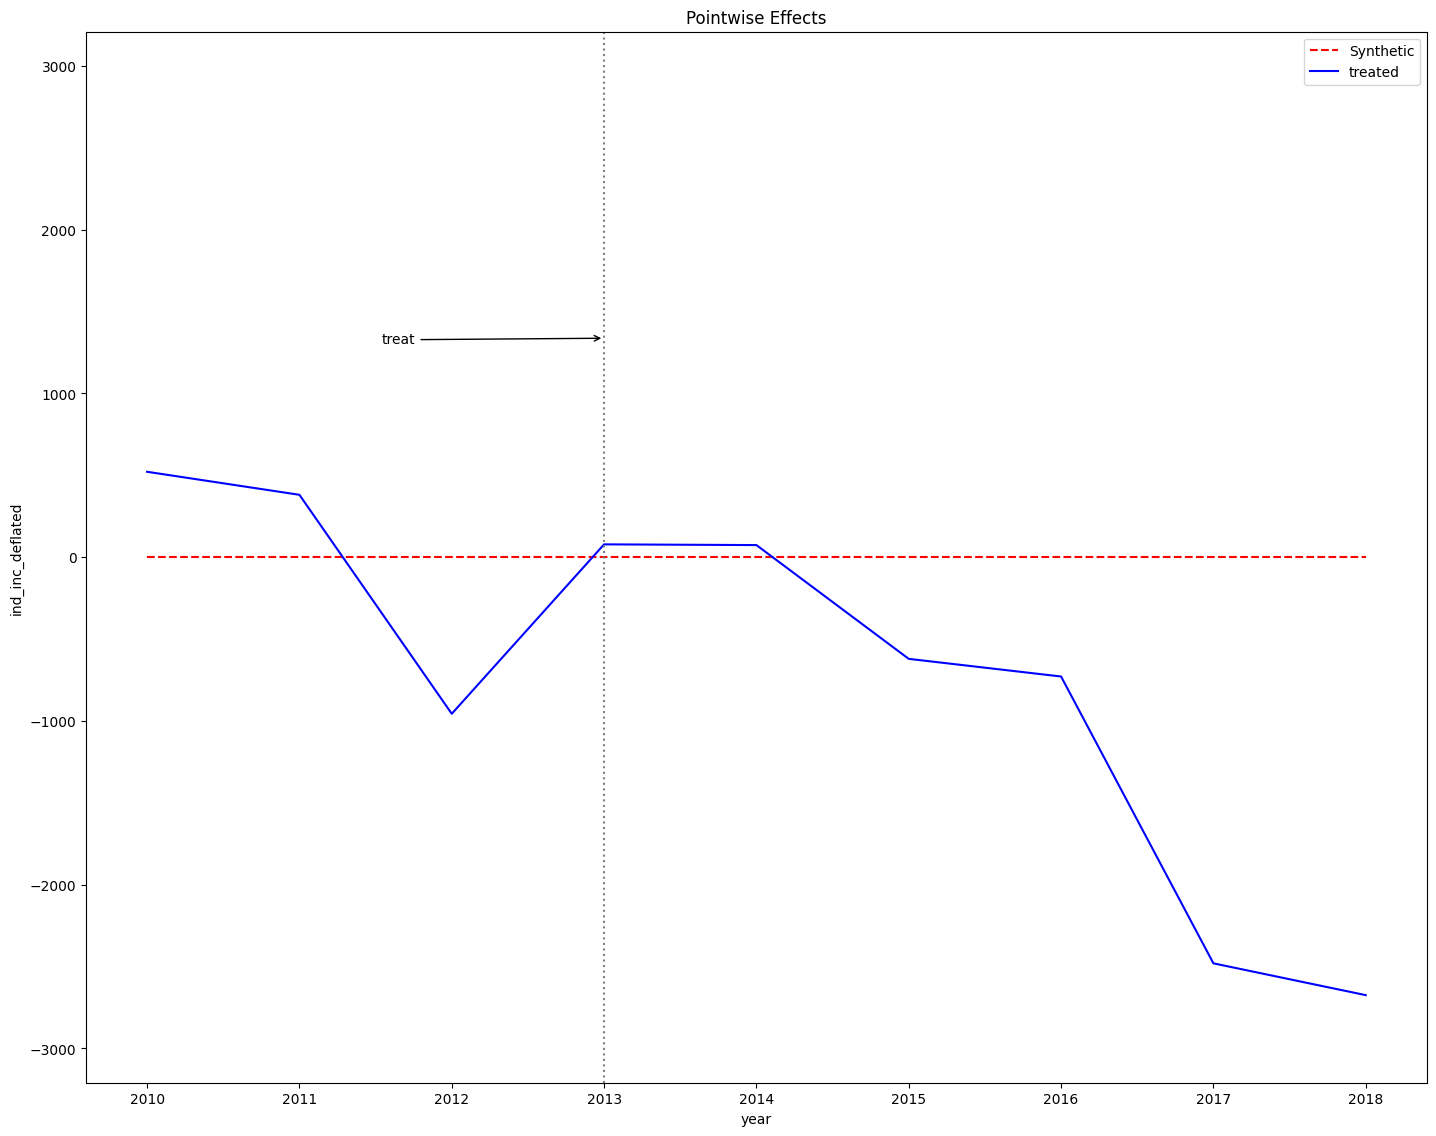

In [10]:
sc.plot(["pointwise"], treated_label="treated", 
            synth_label="Synthetic", treatment_label="treat")

In [45]:
og_format = pd.read_csv('./original_format.csv', index_col=[0,1])

In [2]:
def get_control_matrices(data_object):
    data = data_object['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = data_object['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = data_object['treat_time']
    target_var = data_object['target_var']
    c_out_all = np.array([x for x in data.iloc[:,1:].loc[[target_var]].values])
    c_out = np.array([x for x in data.iloc[:,1:].loc[[target_var]].loc[(slice(None), slice(None, t_time-1)), :].values])
    l_means = data.iloc[:,1:].sort_index().loc[(slice(None), slice(None, t_time-1)), :].groupby(level='var').mean()
    c_cov_mean = np.array([x for x in l_means.values])
    return c_out_all, c_out, c_cov_mean

In [43]:
def get_control_matrices_b(data_object, k_n):
    data = data_object['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = data_object['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = data_object['treat_time']
    target_var = data_object['target_var']
    data.index = data.index.map(lambda idx: (idx[0], idx[1] - t_time))
    sample_weights.index = sample_weights.index - t_time
    data = data.sort_index(ascending=True).copy()
    df_T0 = data.loc[pd.IndexSlice[:, :-1], :]
    if ncol < k_n:
        k_n = ncol
    try:
        kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    except ValueError:
        return None
    idx = kdt.query(df_T0.T, k=k_n, return_distance=False)[0, :]
    select_data = data.iloc[:, idx]
    select_df_T0 = df_T0.iloc[:, idx]
    c_out_all = np.array([x for x in select_data.iloc[:,1:].loc[[target_var]].values])
    c_out = np.array([x for x in select_df_T0.iloc[:,1:].loc[[target_var]].values])
    l_means = select_df_T0.iloc[:,1:].sort_index().groupby(level='var').mean()
    c_cov_mean = np.array([x for x in l_means.values])
    return c_out_all, c_out, c_cov_mean

In [6]:
def get_treat_matrices(data_object):
    data = data_object['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = data_object['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = data_object['treat_time']
    target_var = data_object['target_var']
    t_out_all = np.array([[x] for x in data.iloc[:,0][target_var].values])
    t_out = np.array([[x] for x in data.iloc[:,0][target_var][:t_time-1].values])
    l_means = data.iloc[:,:1].sort_index().loc[(slice(None), slice(None, t_time-1)), :].groupby(level='var').mean().mean(axis=1)
    t_cov_mean = np.array([[x] for x in l_means.values])
    return t_out_all, t_out, t_cov_mean

In [ ]:
def rescale_covariate_variance(self, treated_covariates, control_covariates, n_covariates):
    '''Rescale covariates to be unit variance'''

        #Combine control and treated into one big dataframe, over which we will compute variance for each covariate
    big_dataframe = np.concatenate((treated_covariates, control_covariates), axis=1)

        #Rescale each covariate to have unit variance
    big_dataframe /= np.apply_along_axis(np.std, 0, big_dataframe)

        #Re-seperate treated and control from big dataframe
    treated_covariates = big_dataframe[:,0].reshape(n_covariates, 1) #First column is treated unit
    control_covariates = big_dataframe[:,1:] #All other columns are control units

        #Return covariate matices with unit variance
    return treated_covariates, control_covariates

In [10]:
import pickle

# Unpickle the dictionary from the file
with open('data.pkl', 'rb') as file:
    data_object = pickle.load(file)

get_treat_matrices(data_object)

(array([[1460.6741573 ],
        [1300.10834236],
        [   0.        ],
        [1027.69230769],
        [ 968.7184662 ],
        [   0.        ],
        [   0.        ],
        [   0.        ],
        [   0.        ]]),
 array([[1460.6741573 ],
        [1300.10834236],
        [   0.        ],
        [1027.69230769]]),
 array([[  0.        ],
        [  0.        ],
        [ 20.5       ],
        [947.11870184],
        [  0.        ],
        [  0.        ],
        [  0.        ],
        [  0.        ],
        [  0.        ]]))

In [22]:
get_control_matrices(data_object)

(array([[1745.4954955 ,    0.        ,    0.        , ..., 1440.0756045 ,
            0.        ,  544.66230937],
        [1438.15822746,    0.        ,  441.31092803, ...,    0.        ,
            0.        ,  450.28512506],
        [1486.34453782,    0.        ,  441.52309514, ...,    0.        ,
            0.        , 1130.52415211],
        ...,
        [1391.6500994 ,    0.        ,    0.        , ...,    0.        ,
          681.0707437 , 1178.78192534],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
          755.80002558, 1157.83807664],
        [1244.57034939,    0.        , 1461.27741171, ...,    0.        ,
          876.21721703, 1127.81954887]]),
 array([[1745.4954955 ,    0.        ,    0.        , ..., 1440.0756045 ,
            0.        ,  544.66230937],
        [1438.15822746,    0.        ,  441.31092803, ...,    0.        ,
            0.        ,  450.28512506],
        [1486.34453782,    0.        ,  441.52309514, ...,    0.        ,

In [44]:
get_control_matrices_b(data_object, 4228)

4227
pidp        81959733    68008847    68031967    68037407    68041487    \
var   year                                                               
asian -4.0         0.0         0.0         0.0         0.0         0.0   
      -3.0         0.0         0.0         0.0         0.0         0.0   
      -2.0         0.0         0.0         0.0         0.0         0.0   
      -1.0         0.0         0.0         0.0         0.0         0.0   
       0.0         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
other  0.0         0.0         0.0         0.0         0.0         0.0   
       1.0         0.0         0.0         0.0         0.0         0.0   
       2.0         0.0         0.0         0.0         0.0         0.0   
       3.0         0.0         0.0         0.0         0.0         0.0   
       4.0         0.0         0.0         0.0         0.0         0.0   

pidp        68044207    68044887

(array([[1264.99454744, 1581.40814081, 1167.71237575, ..., 6245.33565786,
         6991.05145414, 6354.39006332],
        [1481.48148148, 1541.7989418 , 1473.68421053, ..., 6119.51395451,
         6749.4600432 , 6863.78035903],
        [   0.        ,    0.        ,    0.        , ..., 5908.93631061,
         6256.51720542, 6443.29896907],
        ...,
        [1724.13793103, 1904.43349754,  681.0707437 , ..., 5754.8905784 ,
         6493.50649351, 7367.3870334 ],
        [1244.25287356, 1761.49425287, 1014.36364571, ..., 5687.90650484,
         6347.65625   ,  829.34926594],
        [1313.32082552, 1736.6447985 ,  916.35338346, ...,    0.        ,
         7308.55092648,  758.02620869]]),
 array([[1264.99454744, 1581.40814081, 1167.71237575, ..., 6245.33565786,
         6991.05145414, 6354.39006332],
        [1481.48148148, 1541.7989418 , 1473.68421053, ..., 6119.51395451,
         6749.4600432 , 6863.78035903],
        [   0.        ,    0.        ,    0.        , ..., 5908.93631061,